In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import xgboost as xgb
import time
from statistics import mode

**Reading dataset**

In [ ]:
df1 = pd.read_csv("/content/drive/MyDrive/CICIDS-2017_dataset/folder/CICIDS_2017_1.csv", encoding='ISO-8859-1')
df2 = pd.read_csv("/content/drive/MyDrive/CICIDS-2017_dataset/folder/CICIDS_2017_2.csv", encoding='ISO-8859-1')
df3 = pd.read_csv("/content/drive/MyDrive/CICIDS-2017_dataset/folder/CICIDS_2017_3.csv", encoding='ISO-8859-1')
df4 = pd.read_csv("/content/drive/MyDrive/CICIDS-2017_dataset/folder/CICIDS_2017_4.csv", encoding='ISO-8859-1')

In [ ]:
df5 = pd.read_csv("CICIDS_2017_5.csv", encoding='ISO-8859-1')
df6 = pd.read_csv("CICIDS_2017_6.csv", encoding='ISO-8859-1')
df7 = pd.read_csv("CICIDS_2017_7.csv", encoding='ISO-8859-1')
df8 = pd.read_csv("CICIDS_2017_8.csv", encoding='ISO-8859-1')

In [ ]:
data = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8])

In [ ]:
data

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
54865,3,2,0,12,0,6,6,6.0,0.00000,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
55054,109,1,1,6,6,6,6,6.0,0.00000,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
55055,52,1,1,6,6,6,6,6.0,0.00000,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
46236,34,1,1,6,6,6,6,6.0,0.00000,6,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
54863,3,2,0,12,0,6,6,6.0,0.00000,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,32215,4,2,112,152,28,28,28.0,0.00000,76,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
53,324,2,2,84,362,42,42,42.0,0.00000,181,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
58030,82,2,1,31,6,31,0,15.5,21.92031,6,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
53,1048635,6,2,192,256,32,32,32.0,0.00000,128,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2830743 entries, 54865 to 53
Data columns (total 78 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Flow Duration                int64  
 1   Total Fwd Packets            int64  
 2   Total Backward Packets       int64  
 3   Total Length of Fwd Packets  int64  
 4   Total Length of Bwd Packets  int64  
 5   Fwd Packet Length Max        int64  
 6   Fwd Packet Length Min        int64  
 7   Fwd Packet Length Mean       float64
 8   Fwd Packet Length Std        float64
 9   Bwd Packet Length Max        int64  
 10  Bwd Packet Length Min        int64  
 11  Bwd Packet Length Mean       float64
 12  Bwd Packet Length Std        float64
 13  Flow Bytes/s                 float64
 14  Flow Packets/s               float64
 15  Flow IAT Mean                float64
 16  Flow IAT Std                 float64
 17  Flow IAT Max                 int64  
 18  Flow IAT Min                 int64  
 19  Fwd IA

In [ ]:
duplicates = data.duplicated()

# Check for the number of duplicates
num_duplicates = duplicates.sum()

# Optionally, remove duplicates
data = data.drop_duplicates()

print(f"Number of duplicate rows found: {num_duplicates}")

Number of duplicate rows found: 596780


In [ ]:
df = pd.DataFrame(data)

# Count total missing values
total_missing_values = df.isnull().sum().sum()

# Print the total count of missing values
print(total_missing_values)

238


In [ ]:
data.Label.value_counts()

Label
BENIGN              2273097
DoS Hulk             231073
PortScan             158930
DDoS                 128027
DoS GoldenEye         10293
FTP-Patator            7938
SSH-Patator            5897
DoS slowloris          5796
DoS Slowhttptest       5499
Web Attack             2180
Bot                    1966
Infiltration             36
Heartbleed               11
Name: count, dtype: int64

**Normalization**

In [1]:
# Z-score normalization
features = data.dtypes[data.dtypes != 'object'].index
data[features] = data[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
data = data.fillna(0)

NameError: name 'data' is not defined

In [ ]:
data

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
54865,-0.439347,-0.009819,-0.010421,-0.053765,-0.007142,-0.281099,-0.210703,-0.280518,-0.245069,-0.447423,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,BENIGN
55054,-0.439344,-0.011153,-0.009418,-0.054365,-0.007139,-0.281099,-0.210703,-0.280518,-0.245069,-0.444340,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,BENIGN
55055,-0.439345,-0.011153,-0.009418,-0.054365,-0.007139,-0.281099,-0.210703,-0.280518,-0.245069,-0.444340,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,BENIGN
46236,-0.439346,-0.011153,-0.009418,-0.054365,-0.007139,-0.281099,-0.210703,-0.280518,-0.245069,-0.444340,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,BENIGN
54863,-0.439347,-0.009819,-0.010421,-0.053765,-0.007142,-0.281099,-0.210703,-0.280518,-0.245069,-0.447423,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,-0.438390,-0.007151,-0.008416,-0.043758,-0.007075,-0.250424,0.153902,-0.162296,-0.245069,-0.408376,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,BENIGN
53,-0.439337,-0.009819,-0.008416,-0.046560,-0.006982,-0.230903,0.385923,-0.087065,-0.245069,-0.354429,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,BENIGN
58030,-0.439344,-0.009819,-0.009418,-0.051863,-0.007139,-0.246240,-0.310140,-0.229468,-0.167112,-0.444340,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,BENIGN
53,-0.408187,-0.004484,-0.008416,-0.035753,-0.007029,-0.244846,0.220194,-0.140802,-0.245069,-0.381659,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,BENIGN


In [ ]:
from sklearn.preprocessing import LabelEncoder
# Encode the 'Label' column before splitting
labelencoder = LabelEncoder()
data['Label'] = labelencoder.fit_transform(data['Label'])

In [ ]:
data.Label.value_counts()

Label
0     2273097
4      231073
10     158930
2      128027
3       10293
7        7938
11       5897
6        5796
5        5499
12       2180
1        1966
9          36
8          11
Name: count, dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2830743 entries, 54865 to 53
Data columns (total 78 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Flow Duration                float64
 1   Total Fwd Packets            float64
 2   Total Backward Packets       float64
 3   Total Length of Fwd Packets  float64
 4   Total Length of Bwd Packets  float64
 5   Fwd Packet Length Max        float64
 6   Fwd Packet Length Min        float64
 7   Fwd Packet Length Mean       float64
 8   Fwd Packet Length Std        float64
 9   Bwd Packet Length Max        float64
 10  Bwd Packet Length Min        float64
 11  Bwd Packet Length Mean       float64
 12  Bwd Packet Length Std        float64
 13  Flow Bytes/s                 float64
 14  Flow Packets/s               float64
 15  Flow IAT Mean                float64
 16  Flow IAT Std                 float64
 17  Flow IAT Max                 float64
 18  Flow IAT Min                 float64
 19  Fwd IA

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Split the data into train (60%) and test (40%) sets
train_data, test_data = train_test_split(data, test_size=0.40, random_state=42)

In [ ]:
train_data.shape

(2123057, 78)

In [ ]:
train_data.Label.value_counts()

Label
0     1364100
4      138428
10      95267
2       76824
3        6228
7        4734
11       3539
6        3463
5        3341
12       1304
1        1185
9          24
8           8
Name: count, dtype: int64

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1698445 entries, 80 to 80
Data columns (total 78 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Flow Duration                float64
 1   Total Fwd Packets            float64
 2   Total Backward Packets       float64
 3   Total Length of Fwd Packets  float64
 4   Total Length of Bwd Packets  float64
 5   Fwd Packet Length Max        float64
 6   Fwd Packet Length Min        float64
 7   Fwd Packet Length Mean       float64
 8   Fwd Packet Length Std        float64
 9   Bwd Packet Length Max        float64
 10  Bwd Packet Length Min        float64
 11  Bwd Packet Length Mean       float64
 12  Bwd Packet Length Std        float64
 13  Flow Bytes/s                 float64
 14  Flow Packets/s               float64
 15  Flow IAT Mean                float64
 16  Flow IAT Std                 float64
 17  Flow IAT Max                 float64
 18  Flow IAT Min                 float64
 19  Fwd IAT T

In [ ]:
test_data.Label.value_counts()

Label
0     908997
4      92645
10     63663
2      51203
3       4065
7       3204
11      2358
6       2333
5       2158
12       876
1        781
9         12
8          3
Name: count, dtype: int64

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1132298 entries, 50545 to 443
Data columns (total 78 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   Flow Duration                1132298 non-null  float64
 1   Total Fwd Packets            1132298 non-null  float64
 2   Total Backward Packets       1132298 non-null  float64
 3   Total Length of Fwd Packets  1132298 non-null  float64
 4   Total Length of Bwd Packets  1132298 non-null  float64
 5   Fwd Packet Length Max        1132298 non-null  float64
 6   Fwd Packet Length Min        1132298 non-null  float64
 7   Fwd Packet Length Mean       1132298 non-null  float64
 8   Fwd Packet Length Std        1132298 non-null  float64
 9   Bwd Packet Length Max        1132298 non-null  float64
 10  Bwd Packet Length Min        1132298 non-null  float64
 11  Bwd Packet Length Mean       1132298 non-null  float64
 12  Bwd Packet Length Std        1132298 non-null  

In [ ]:
# retain the minority class instances and sample the majority class instances
Bot_Rare = train_data[(train_data['Label']==1)]
Infilteration_Rare = train_data[(train_data['Label']==9)]
Heartbleed_Rare = train_data[(train_data['Label']==8)]

In [ ]:
Bot_Rare.shape

(1185, 78)

In [ ]:
train_data.shape

(1698445, 78)

In [ ]:
Bot_Rare

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
8080,-0.437106,-0.007151,-0.007413,-0.033952,-0.007083,-0.013386,-0.310140,-0.030641,0.100044,-0.381659,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,1
52732,-0.439347,-0.011153,-0.009418,-0.054365,-0.007139,-0.281099,-0.210703,-0.280518,-0.245069,-0.444340,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,1
8080,-0.409720,-0.008485,-0.007413,-0.054965,-0.007134,-0.289465,-0.310140,-0.312760,-0.245069,-0.444340,...,0.002553,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,1
8080,-0.409563,-0.008485,-0.007413,-0.054965,-0.007134,-0.289465,-0.310140,-0.312760,-0.245069,-0.444340,...,0.002553,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,1
52936,-0.439345,-0.011153,-0.009418,-0.054365,-0.007139,-0.281099,-0.210703,-0.280518,-0.245069,-0.444340,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2902,-0.439346,-0.011153,-0.009418,-0.054365,-0.007139,-0.281099,-0.210703,-0.280518,-0.245069,-0.444340,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,1
8080,-0.408762,-0.008485,-0.007413,-0.054965,-0.007134,-0.289465,-0.310140,-0.312760,-0.245069,-0.444340,...,0.002553,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,1
8080,-0.436874,-0.007151,-0.007413,-0.034252,-0.007083,-0.017569,-0.310140,-0.034671,0.094712,-0.381659,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,1
8080,-0.437220,-0.007151,-0.007413,-0.034352,-0.007083,-0.018963,-0.310140,-0.036014,0.092934,-0.381659,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,1


In [ ]:
Infilteration_Rare.shape

(24, 78)

In [ ]:
Infilteration_Rare

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
444,-0.439286,-0.009819,-0.010421,-0.053765,-0.007142,-0.281099,-0.210703,-0.280518,-0.245069,-0.447423,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,9
444,0.828389,-0.005817,-0.004405,-0.040856,-0.007013,-0.159791,-0.310140,-0.161222,-0.106864,-0.310244,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,9
444,-0.290620,0.007522,0.004618,-0.054965,-0.007102,-0.289465,-0.310140,-0.312760,-0.245069,-0.444340,...,0.002553,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,9
444,1.542478,0.030198,0.023668,1.135598,-0.006939,1.746272,-0.310140,1.685252,1.552151,-0.310244,...,0.002545,0.454486,0.817110,0.563024,-0.090406,0.566395,3.127570,1.161586,-0.027879,9
444,-0.439346,-0.009819,-0.010421,-0.053765,-0.007142,-0.281099,-0.210703,-0.280518,-0.245069,-0.447423,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,9
444,3.125580,5.824726,4.375033,232.241755,0.004455,1.485531,-0.210703,2.538005,0.689430,-0.444340,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.109460,-0.356868,-0.338993,9
444,3.064663,0.047539,0.029684,1.521445,-0.007036,1.746272,-0.210703,1.568516,1.553001,-0.444340,...,0.002545,4.473331,7.490034,4.817884,1.407267,2.005239,11.296183,3.451579,0.457124,9
444,2.529503,0.022195,0.015647,0.612863,-0.007073,1.333548,-0.210703,1.066630,1.056629,-0.444340,...,0.002545,0.847478,0.135514,0.572316,0.898203,1.023440,4.126922,1.900294,0.555568,9
444,3.019208,0.659806,0.494899,17.101233,-0.005806,1.142523,-0.210703,1.515282,0.582914,-0.444340,...,0.002545,33.639301,-0.104565,21.199345,37.847854,1.404310,-0.109460,1.346263,1.437288,9
444,1.240659,-0.009819,-0.009418,-0.048361,-0.007139,-0.205805,-0.210703,-0.135428,-0.109274,-0.444340,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,2.039095,-0.109460,1.961853,2.079318,9


In [ ]:
Infilteration_Rare.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 444 to 444
Data columns (total 78 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Flow Duration                24 non-null     float64
 1   Total Fwd Packets            24 non-null     float64
 2   Total Backward Packets       24 non-null     float64
 3   Total Length of Fwd Packets  24 non-null     float64
 4   Total Length of Bwd Packets  24 non-null     float64
 5   Fwd Packet Length Max        24 non-null     float64
 6   Fwd Packet Length Min        24 non-null     float64
 7   Fwd Packet Length Mean       24 non-null     float64
 8   Fwd Packet Length Std        24 non-null     float64
 9   Bwd Packet Length Max        24 non-null     float64
 10  Bwd Packet Length Min        24 non-null     float64
 11  Bwd Packet Length Mean       24 non-null     float64
 12  Bwd Packet Length Std        24 non-null     float64
 13  Flow Bytes/s            

In [ ]:
Heartbleed_Rare.shape

(8, 78)

In [ ]:
Heartbleed_Rare

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
444,3.105567,3.729145,2.022889,1.317114,3.474219,7.786556,-0.31014,-0.286491,0.146560,8.479977,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,8
444,3.104398,3.710471,2.109115,1.317114,3.473981,7.786556,-0.31014,-0.286360,0.147539,6.248127,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,8
444,3.104423,3.714472,2.125157,1.172221,3.474621,5.767551,-0.31014,-0.289173,0.050861,6.248127,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,8
444,3.104360,3.723810,2.063997,1.172221,3.474621,5.767551,-0.31014,-0.289232,0.050492,7.736027,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,8
444,3.104386,3.698465,2.086054,1.172221,3.474621,5.767551,-0.31014,-0.289071,0.051497,7.736027,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,8
444,3.105519,3.698465,2.084049,0.882435,3.475901,1.729540,-0.31014,-0.294665,-0.136582,8.479977,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,8
444,3.104320,3.725144,2.061992,2.032173,3.444951,7.786556,-0.31014,-0.272759,0.203195,6.248127,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,8
444,3.105477,3.718474,2.000832,1.317114,3.473981,7.786556,-0.31014,-0.286416,0.147118,6.248127,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,8


In [ ]:
# Drop instances with Bot, Infiltration, and Heartbleed attacks
train_data = train_data.drop(train_data[train_data['Label'] == 1].index)
train_data = train_data.drop(train_data[train_data['Label'] == 9].index)
train_data = train_data.drop(train_data[train_data['Label'] == 8].index)

# Reset the index
train_data = train_data.reset_index(drop=True)


In [ ]:
train_data.shape

(1689606, 78)

In [ ]:
train_data.Label.value_counts()

Label
0     1358053
4      138428
10      93692
2       76824
3        6228
7        4734
11       3539
6        3463
5        3341
12       1304
Name: count, dtype: int64

In [ ]:
Major = train_data
Major

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,-0.439240,-0.009819,-0.010421,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,-0.447423,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0
1,-0.439341,-0.009819,-0.008416,-0.046960,-0.006993,-0.233691,0.352777,-0.097812,-0.245069,-0.361108,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0
2,-0.439346,-0.009819,-0.010421,-0.053765,-0.007142,-0.281099,-0.210703,-0.280518,-0.245069,-0.447423,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0
3,-0.434182,-0.009819,-0.008416,-0.047561,-0.007060,-0.237874,0.303058,-0.113933,-0.245069,-0.399642,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0
4,-0.439345,-0.011153,-0.009418,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,-0.447423,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1689601,-0.438294,-0.009819,-0.010421,-0.054965,-0.007142,-0.289465,-0.310140,-0.312760,-0.245069,-0.447423,...,0.002545,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0
1689602,2.105411,-0.004484,-0.004405,-0.013239,-0.002018,0.266877,-0.310140,0.060713,0.329098,2.528377,...,0.002545,-0.118001,-0.104565,-0.144436,-0.092325,3.266344,-0.10946,3.151992,3.320574,4
1689603,-0.434876,-0.008485,-0.004405,-0.021044,-0.002018,0.183216,-0.310140,0.294469,0.450987,1.784427,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,4
1689604,-0.434665,-0.009819,-0.008416,-0.047761,-0.007071,-0.239269,0.286485,-0.119307,-0.245069,-0.406321,...,0.002556,-0.125734,-0.104565,-0.149326,-0.101016,-0.351926,-0.10946,-0.356868,-0.338993,0


In [ ]:
Infilteration_Rare = Infilteration_Rare

**Define and Compile the GAN Models**

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, ReLU, Input
from tensorflow.keras.optimizers import Adam
import numpy as np

# Build the Generator
def build_generator(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim))
    model.add(ReLU())
    model.add(Dense(512))
    model.add(ReLU())
    model.add(Dense(1024))
    model.add(ReLU())
    model.add(Dense(output_dim, activation='tanh'))
    return model

# Build the Discriminator
def build_discriminator(input_dim):
    model = Sequential()
    model.add(Dense(1024, input_dim=input_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Create the generator and discriminator
input_dim = 100
number_of_features = 77  # Exclude the label column
generator = build_generator(input_dim=input_dim, output_dim=number_of_features)
discriminator = build_discriminator(input_dim=number_of_features)

# Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

# Build and compile the combined model (GAN)
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(input_dim,))
    generated_data = generator(gan_input)
    gan_output = discriminator(generated_data)
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return gan

gan = build_gan(generator, discriminator)


**Train the GAN**

In [ ]:
# Function to train the GAN
def train_gan(generator, discriminator, gan, real_data, batch_size, epochs, noise_dim):
    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, real_data.shape[0], batch_size)
        real_samples = real_data[idx]
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        synthetic_samples = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_samples, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(synthetic_samples, np.zeros((batch_size, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Print the progress
        print(f"{epoch+1}/{epochs} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")

# Prepare the real data for each class
Bot_Rare_features = Bot_Rare.drop(columns=['Label']).values
Infiltration_Rare_features = Infilteration_Rare.drop(columns=['Label']).values
Heartbleed_Rare_features = Heartbleed_Rare.drop(columns=['Label']).values

# Train the GAN for each class
print("Training GAN for Bot class")
train_gan(generator, discriminator, gan, Bot_Rare_features, batch_size=10, epochs=20, noise_dim=input_dim)

print("Training GAN for Infiltration class")
train_gan(generator, discriminator, gan, Infiltration_Rare_features, batch_size=1, epochs=20, noise_dim=input_dim)

print("Training GAN for Heartbleed class")
train_gan(generator, discriminator, gan, Heartbleed_Rare_features, batch_size=1, epochs=20, noise_dim=input_dim)


Training GAN for Bot class
1/1 [==============================] - 0s 239ms/step
1/20 [D loss: 0.6882470846176147, acc.: 60.00000014901161] [G loss: 0.7308748960494995]
1/1 [==============================] - 0s 31ms/step
2/20 [D loss: 0.6741732358932495, acc.: 54.999998956918716] [G loss: 0.7120851278305054]
1/1 [==============================] - 0s 35ms/step
3/20 [D loss: 0.625371515750885, acc.: 50.0] [G loss: 0.6991023421287537]
1/1 [==============================] - 0s 35ms/step
4/20 [D loss: 0.5934554189443588, acc.: 50.0] [G loss: 0.6825627684593201]
1/1 [==============================] - 0s 33ms/step
5/20 [D loss: 0.5478751361370087, acc.: 50.0] [G loss: 0.6682642102241516]
1/1 [==============================] - 0s 34ms/step
6/20 [D loss: 0.5670780837535858, acc.: 50.0] [G loss: 0.7005177140235901]
1/1 [==============================] - 0s 44ms/step
7/20 [D loss: 0.5459027588367462, acc.: 50.0] [G loss: 0.7058075666427612]
1/1 [==============================] - 0s 38ms/step
8/20 

**Generate Synthetic Data**

In [ ]:
# Function to generate synthetic data
def generate_synthetic_data(generator, num_samples, noise_dim):
    noise = np.random.normal(0, 1, (num_samples, noise_dim))
    synthetic_data = generator.predict(noise)
    return synthetic_data

# Generate 10,000 samples for each class
num_samples = 10000
synthetic_bot = generate_synthetic_data(generator, num_samples, input_dim)
synthetic_infiltration = generate_synthetic_data(generator, num_samples, input_dim)
synthetic_heartbleed = generate_synthetic_data(generator, num_samples, input_dim)

# Convert synthetic data to DataFrame
synthetic_bot_df = pd.DataFrame(synthetic_bot, columns=train_data.drop(columns=['Label']).columns)
synthetic_bot_df['Label'] = 1  # Assign the label for Bot

synthetic_infiltration_df = pd.DataFrame(synthetic_infiltration, columns=train_data.drop(columns=['Label']).columns)
synthetic_infiltration_df['Label'] = 9  # Assign the label for Infiltration

synthetic_heartbleed_df = pd.DataFrame(synthetic_heartbleed, columns=train_data.drop(columns=['Label']).columns)
synthetic_heartbleed_df['Label'] = 8  # Assign the label for Heartbleed


313/313 [==============================] - 1s 4ms/step


In [ ]:
# Generate synthetic data
num_samples = 10000
synthetic_bot = generate_synthetic_data(generator, num_samples, input_dim)
synthetic_infiltration = generate_synthetic_data(generator, num_samples, input_dim)
synthetic_heartbleed = generate_synthetic_data(generator, num_samples, input_dim)

# Convert synthetic data to DataFrame
synthetic_bot_df = pd.DataFrame(synthetic_bot, columns=train_data.drop(columns=['Label']).columns)
synthetic_bot_df['Label'] = 1  # Assign the label for Bot

synthetic_infiltration_df = pd.DataFrame(synthetic_infiltration, columns=train_data.drop(columns=['Label']).columns)
synthetic_infiltration_df['Label'] = 9  # Assign the label for Infiltration

synthetic_heartbleed_df = pd.DataFrame(synthetic_heartbleed, columns=train_data.drop(columns=['Label']).columns)
synthetic_heartbleed_df['Label'] = 8  # Assign the label for Heartbleed

# Combine synthetic data with original training data
combined_bot = pd.concat([Bot_Rare, synthetic_bot_df], axis=0)
combined_infiltration = pd.concat([Infilteration_Rare, synthetic_infiltration_df], axis=0)
combined_heartbleed = pd.concat([Heartbleed_Rare, synthetic_heartbleed_df], axis=0)

# Shuffle the combined data
combined_bot = combined_bot.sample(frac=1).reset_index(drop=True)
combined_infiltration = combined_infiltration.sample(frac=1).reset_index(drop=True)
combined_heartbleed = combined_heartbleed.sample(frac=1).reset_index(drop=True)

# Verify the new class distribution
print("New Bot class count:", combined_bot['Label'].value_counts())
print("New Infiltration class count:", combined_infiltration['Label'].value_counts())
print("New Heartbleed class count:", combined_heartbleed['Label'].value_counts())


313/313 [==============================] - 1s 4ms/step
New Bot class count: Label
1    11185
Name: count, dtype: int64
New Infiltration class count: Label
9    10024
Name: count, dtype: int64
New Heartbleed class count: Label
8    10008
Name: count, dtype: int64


In [ ]:
# Combine the synthetic data with the original training data
augmented_train_data = pd.concat([train_data, combined_bot, combined_infiltration, combined_heartbleed], axis=0)

# Shuffle the augmented training data
augmented_train_data = augmented_train_data.sample(frac=1).reset_index(drop=True)

# Verify the new class distribution
augmented_train_data.Label.value_counts()

Label
0     1358053
4      138428
10      93692
2       76824
1       11185
9       10024
8       10008
3        6228
7        4734
11       3539
6        3463
5        3341
12       1304
Name: count, dtype: int64

In [ ]:
import pandas as pd

# Check if 'Label' column exists
if 'Label' in augmented_train_data.columns:
    print("The 'Label' column is present in the DataFrame.")
else:
    print("The 'Label' column is not present in the DataFrame.")


The 'Label' column is present in the DataFrame.


In [ ]:
X_train = augmented_train_data.drop(columns=['Label'])
y_train = augmented_train_data['Label']

In [ ]:
X_test = test_data.drop(columns=['Label'])
y_test = test_data['Label']

In [ ]:
# Check the unique labels in the test data
unique_labels = np.unique(y_test)
print("Unique labels in the test data:", unique_labels)


Unique labels in the test data: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


**Classification using RF**

Original Data Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    908997
           1       0.61      0.65      0.63       781
           2       1.00      1.00      1.00     51203
           3       1.00      1.00      1.00      4065
           4       1.00      1.00      1.00     92645
           5       0.95      0.99      0.97      2158
           6       1.00      1.00      1.00      2333
           7       1.00      1.00      1.00      3204
           8       1.00      0.67      0.80         3
           9       0.82      0.75      0.78        12
          10       0.99      1.00      1.00     63663
          11       1.00      0.99      1.00      2358
          12       1.00      0.91      0.95       876

    accuracy                           1.00   1132298
   macro avg       0.95      0.92      0.93   1132298
weighted avg       1.00      1.00      1.00   1132298

Accuracy: 0.9984
Precision: 

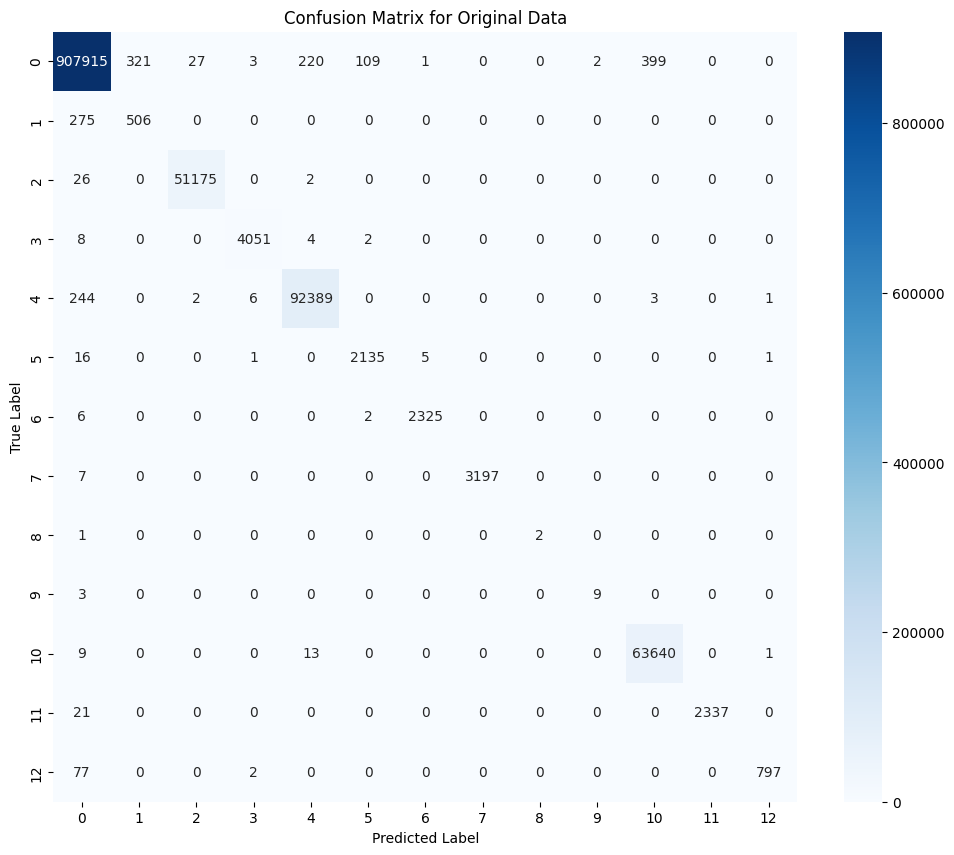

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Train Random Forest on the original data
rf_original = RandomForestClassifier(n_estimators=100, random_state=1)
rf_original.fit(X_train, y_train)

# Predict and evaluate the model on the original data
y_pred_original = rf_original.predict(X_test)

# Metrics for the original data
accuracy_original = accuracy_score(y_test, y_pred_original)
precision_original = precision_score(y_test, y_pred_original, average='weighted')
recall_original = recall_score(y_test, y_pred_original, average='weighted')
f1_original = f1_score(y_test, y_pred_original, average='weighted')

print("Original Data Random Forest Classification Report:")
print(classification_report(y_test, y_pred_original, target_names=[
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'
]))
print(f"Accuracy: {accuracy_original:.4f}")
print(f"Precision: {precision_original:.4f}")
print(f"Recall: {recall_original:.4f}")
print(f"F1 Score: {f1_original:.4f}")

# Confusion matrix for the original data
cm_original = confusion_matrix(y_test, y_pred_original)

# Plot confusion matrix for the original data
plt.figure(figsize=(12, 10))
sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
            yticklabels=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
plt.title('Confusion Matrix for Original Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
